In [78]:
from sklearn.cluster import KMeans
import numpy as np
import scipy as sp
import sys
sys.path.append('../corv/src')
sys.path.append('../wdtools')

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
import pandas as pd
import corv

### Query
from astroquery.sdss import SDSS
from astroquery.gaia import Gaia
from astropy import constants as c
import data_selector as ds

import wdtools
import corv


In [79]:
d1 = pd.read_csv('data/wd_spectra.csv')
d1 = Table.from_pandas(d1)

catalog = Table.read('data/00_raw.fits')
print(len(catalog))

2000


In [80]:
spAll = Table.read('~/Downloads/spAll-master.fits')

In [81]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join_skycoord
from astropy import table

print(spAll.keys())

print(spAll[['RACAT', 'DECCAT']])

spAll = spAll[spAll['DECCAT'] < 90]
spAll = spAll[spAll['DECCAT'] > -90]

catalog['wd_pos'] = SkyCoord(catalog['wd_ra'], catalog['wd_dec'], unit='deg')
spAll['wd_pos'] = SkyCoord(spAll['RACAT'], spAll['DECCAT'], unit='deg')

join_func = table.join_skycoord(5 * u.arcsecond)
sdss5_catalog = table.join(catalog, spAll, join_funcs={'wd_pos': join_skycoord(5 * u.arcsec)})

['PROGRAMNAME', 'SURVEY', 'FIELDQUALITY', 'FIELDSN2', 'EXP_DISP_MED', 'FIBERID_LIST', 'LAMBDA_EFF', 'BLUEFIBER', 'ZOFFSET', 'XFOCAL', 'YFOCAL', 'CALIBFLUX', 'CALIBFLUX_IVAR', 'GAIA_BP', 'GAIA_RP', 'GAIA_G', 'CADENCE', 'FIRSTCARTON', 'CARTON_TO_TARGET_PK', 'RACAT', 'DECCAT', 'COORD_EPOCH', 'PMRA', 'PMDEC', 'PARALLAX', 'CATALOGID', 'FIBER2MAG', 'PSFMAG', 'FIELD', 'DESIGNS', 'CONFIGS', 'NEXP', 'EXPTIME', 'AIRMASS', 'SEEING20', 'SEEING50', 'SEEING80', 'ASSIGNED', 'ON_TARGET', 'VALID', 'HEALPIX', 'HEALPIXGRP', 'HEALPIX_PATH', 'MJD_FINAL', 'MJD_LIST', 'TAI_LIST', 'FIELDSNR2G_LIST', 'FIELDSNR2R_LIST', 'FIELDSNR2I_LIST', 'RA_LIST', 'DEC_LIST', 'MOON_DIST', 'MOON_PHASE', 'EBV', 'EBV_TYPE', 'WISE_MAG', 'TWOMASS_MAG', 'GUVCAT_MAG', 'GAIA_PARALLAX', 'GAIA_PMRA', 'GAIA_PMDEC', 'FIBER_OFFSET', 'SPEC_FILE', 'XCSAO_RV', 'XCSAO_ERV', 'XCSAO_RXC', 'XCSAO_TEFF', 'XCSAO_ETEFF', 'XCSAO_LOGG', 'XCSAO_ELOGG', 'XCSAO_FEH', 'XCSAO_EFEH', 'SDSSV_BOSS_TARGET0', 'MJD', 'TARGET_INDEX', 'RUN2D', 'RUN1D', 'OBJTYPE',

In [82]:
print(sdss5_catalog[['wd_pos_id', 'wd_pos_1', 'wd_pos_2']])

wd_pos_id               wd_pos_1                             wd_pos_2              
                        deg,deg                              deg,deg               
--------- ------------------------------------ ------------------------------------
        1  282.1747104774862,68.87804564364284          282.174680344,68.8780229646
        2 284.52493807473326,66.05268178807823      284.5249395214,66.0526791739852
        2 284.52493807473326,66.05268178807823      284.5249395214,66.0526791739852
        2 284.52493807473326,66.05268178807823      284.5249395214,66.0526791739852
        3  281.4294963919218,74.08789889865731          281.429494226,74.0878878168
        4 185.94371024645676,87.09999474037326          185.943708498,87.0999923404
        4 185.94371024645676,87.09999474037326          185.943708498,87.0999923404
        5 312.72058442248834,66.71598920244894    312.720590624137,66.7159929242298
        6  274.7350388022228,60.88033244215783    274.735038716684,60.880331

In [83]:
ADQL_CODE1 = "SELECT \
        sdss.original_ext_source_id as bestobjid,\
        gaia_source.source_id\
        FROM gaiaedr3.gaia_source \
        JOIN gaiaedr3.sdssdr13_best_neighbour as sdss\
        ON gaia_source.source_id = sdss.source_id      \
        WHERE gaia_source.source_id IN {}\
    ".format(tuple(catalog['wd_source_id']))

job1 = Gaia.launch_job(ADQL_CODE1,dump_to_file=False)
d1 = job1.get_results()
print(len(d1))

764


In [84]:
drops = []
bestobjid1 = []

for i in tqdm (range(len(catalog))):
    notfound = False
    a = np.where(d1['source_id'] == catalog['wd_source_id'][i])
    
    try:
        j = a[0][0]
    except:
        notfound = True
        
    if not notfound: 
        try:
            bestobjid1.append(d1['bestobjid'][j])
        except:
            notfound = True
    if notfound:
        drops.append(i)    
        
catalog.remove_rows(drops)
catalog['wd_bestobjid'] = bestobjid1

100%|█████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 6733.88it/s]


In [85]:
print(catalog['wd_bestobjid'])

    wd_bestobjid   
-------------------
1237667136955416672
1237666465330298987
1237666464265994487
1237667207828799608
1237667205679677575
1237663230147231754
1237663230684889911
1237667111726219327
1237664668973989935
1237662224056188974
1237667255616209053
                ...
1237665565542515027
1237668311090593860
1237668336321495175
1237665547825185381
1237667782320324692
1237665566081679524
1237667782317506865
1237667735599841356
1237667782856147342
1237665549973979380
1237663787955978273
Length = 764 rows


In [86]:
from astropy.table import Table, vstack, hstack

stardats = []
iters = len(catalog) // 100

for i in tqdm(range(iters)):
    SDSS_QUERY = """select bestObjID, plate, mjd, fiberID
        from dbo.SpecObjAll
        where bestObjID in {}""".format(tuple(catalog['wd_bestobjid'][100*i:100*i+100]))
    
    stardats.append(SDSS.query_sql(SDSS_QUERY))
spec = vstack(stardats)

100%|████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 746.98it/s]


In [87]:
print(spec)


     bestObjID      plate  mjd  fiberID
------------------- ----- ----- -------
1237657070090321961  3650 55244     485
1237657070090321961  4239 55458     274
1237661136887349316  1430 53002     283
1237661136887349316  3262 54884     597
1237661136887349316  8853 57459     544
1237663784214790322  3650 55244     694
1237663784214790322   408 51821     464
1237664835385688318  1921 53317     625
1237667108500603237  2273 53709     495
1237667113872982045  2342 53742     380
1237667113872982045  5794 56282     772
                ...   ...   ...     ...
1237654391104143521   546 52205     283
1237654652025242137  3804 55267     702
1237655370358915142   775 52295     505
1237657595150729272  2670 54115     540
1237657595150729272   893 52589     453
1237667324336930835  6000 56102     536
1237667430100959263  2349 53734     592
1237667551953420367  2352 53770     127
1237671123220365549  1758 53084     530
1237671260664955017  5306 55926     826
1237671941412946020  2560 54205     367


In [88]:
drops = []
plate = []
mjd = []
fiber = []

for i in tqdm (range(len(catalog))):
    notfound = False
    a = np.where(spec['bestObjID'] == catalog['wd_bestobjid'][i])
    
    try:
        j = a[0][0]
    except:
        notfound = True
        
    if not notfound: 
        try:
            
            plate.append(spec['plate'][j])
            mjd.append(spec['mjd'][j])
            fiber.append(spec['fiberID'][j])
            
            
        except:
            notfound = True
    if notfound:
        drops.append(i)    
        
catalog.remove_rows(drops)
catalog['plate'] = plate
catalog['mjd'] = mjd
catalog['fiber'] = fiber

100%|██████████████████████████████████████████████████████████████████████| 764/764 [00:00<00:00, 27340.78it/s]


In [89]:
print(len(catalog))

93


In [90]:
spec = []
wl = []
fl = []
ivar = []
drops = []
worked = []

for i in tqdm(range(len(catalog))):
    try:
        spec = SDSS.get_spectra_async(plate=plate[i], fiberID=fiber[i], mjd=mjd[i])[0].get_fits()
        
        #print(spec[4].header)
        
        wl.append(10**spec[1].data['loglam'])
        fl.append(spec[1].data['flux'])
        ivar.append(spec[1].data['ivar'])
        worked.append(i)
    except:
        drops.append(i)
        
print(len(wl))
print(len(fl))
print(len(ivar))
        
catalog.remove_rows(drops)
catalog['wd_wl'] = wl
catalog['wd_fl'] = fl
catalog['wd_ivar'] = ivar

  0%|                                                                                    | 0/93 [00:00<?, ?it/s]/home/arseneausm/anaconda3/lib/python3.8/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
100%|██████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 146.76it/s]

93
93
93


In [91]:
print(len(catalog))

93


In [92]:
def pseudonormalize(fl, win = 50):
    cont_fl = np.repeat(np.nan, len(fl))
    
    for i in range(len(fl)):
        if (i - (win / 2)) < 0:
            fl_win = fl[0:(i + (win // 2))]
        else:
            fl_win = fl[(i - (win // 2)) : (i + (win // 2))]
        
        cont_fl[i] = np.percentile(fl_win, 90)
        
    return fl / cont_fl
'''
def spec_split(bands, wl, fl, window_size = 100):
    spec_split = {}
    
    for i in range(len(bands)):
        spec_split[bands.keys()[i]] = np.array([ [wl[
'''

'\ndef spec_split(bands, wl, fl, window_size = 100):\n    spec_split = {}\n    \n    for i in range(len(bands)):\n        spec_split[bands.keys()[i]] = np.array([ [wl[\n'

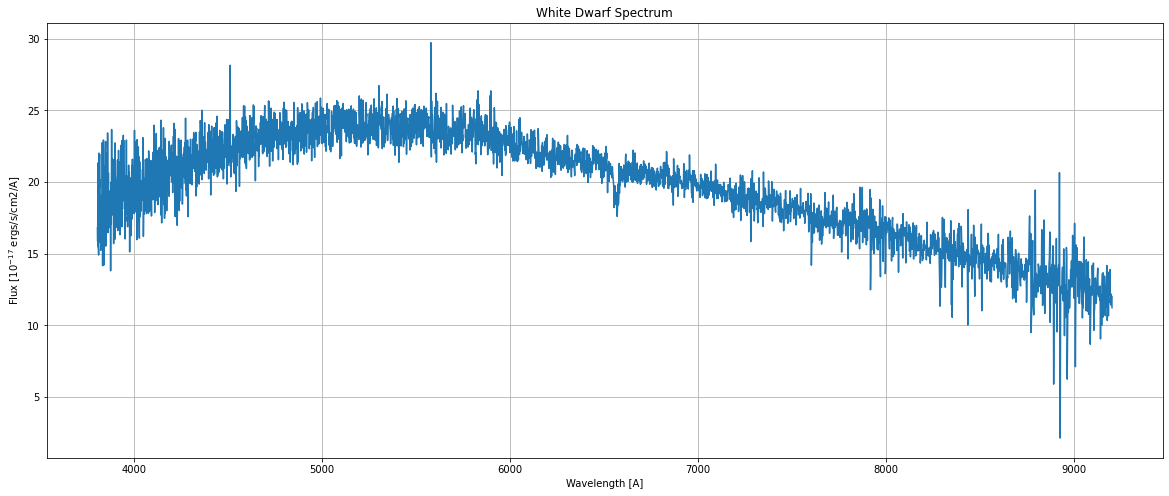

In [93]:
i = 1

plt.figure(figsize=(20,8))

plt.plot(catalog['wd_wl'][i], catalog['wd_fl'][i])
plt.grid()
plt.ylabel(r'Flux [$10^{-17}$ ergs/s/cm2/A]')
plt.xlabel(r'Wavelength [A]')
plt.title('White Dwarf Spectrum')
ax = plt.gca()

plt.show()

1


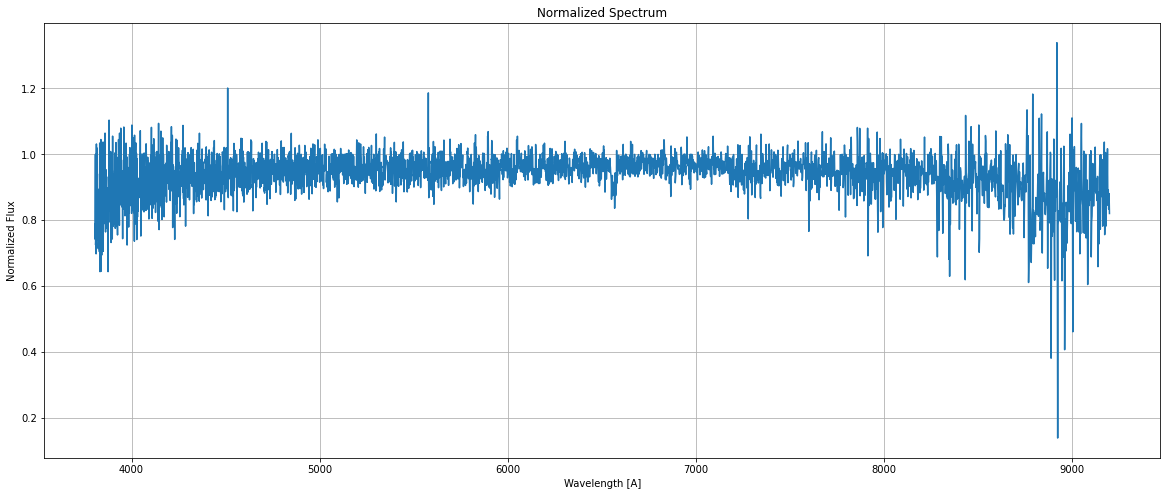

In [94]:
print(i)
nwl = catalog['wd_wl'][i]
nfl = catalog['wd_fl'][i]
cont = pseudonormalize(nfl, 50)

plt.figure(figsize=(20,8))

plt.plot(nwl, cont)
plt.grid()
plt.ylabel(r'Normalized Flux')
plt.xlabel(r'Wavelength [A]')
plt.title('Normalized Spectrum')
ax = plt.gca()

plt.show()

In [95]:
print([np.any(np.isnan(catalog['wd_ivar'][i])) for i in range(len(catalog))])

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


In [96]:
from lmfit import Parameters, fit_report, minimize

rvs = []
e_rvs = []
redchi = []
drops = []

#catalog['wd_ivar'] = [catalog['wd_ivar'][i]  for i in range(len(catalog))]

for i in tqdm(range(len(catalog))):
    corvmodel = corv.models.make_koester_model(resolution = 1)
    param_res, rv_res, rv_init = corv.fit.fit_corv(np.array(catalog['wd_wl'][i]), np.array(catalog['wd_fl'][i]), np.array(catalog['wd_ivar'][i]), corvmodel)
    
    #print(fit_report(rv_res))
            
    rvs.append(rv_res.params['RV'].value)
    e_rvs.append(rv_res.params['RV'].stderr)
    redchi.append(rv_res.redchi)


        
#catalog.remove_rows(drops)
catalog['rv'] = rvs
catalog['e_rv'] = e_rvs
catalog['e_rv'][catalog['e_rv'] == None] = 1e-6
catalog['rechi'] = redchi

100%|███████████████████████████████████████████████████████████████████████████| 93/93 [00:35<00:00,  2.61it/s]


In [97]:
print(len(catalog))
print(len(rvs))
catalog = catalog[catalog['rechi'] < 2.5]
catalog = catalog[(catalog['rv'] / catalog['e_rv']) > 5]
catalog = catalog[catalog['rv'] < 1000]

93
93


In [98]:
print(catalog['e_rv'])

       e_rv       
------------------
             1e-06
             1e-06
             1e-06
             1e-06
2.1672810535439053
1.5335434749811292
13.579735187030625
             1e-06
             1e-06
             1e-06
             1e-06
               ...
             1e-06
             1e-06
             1e-06
             1e-06
23.278694011983703
             1e-06
             1e-06
             1e-06
             1e-06
             1e-06
             1e-06
Length = 40 rows


In [99]:
catalog['e_rv'] = np.array(catalog['e_rv']).astype(float)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


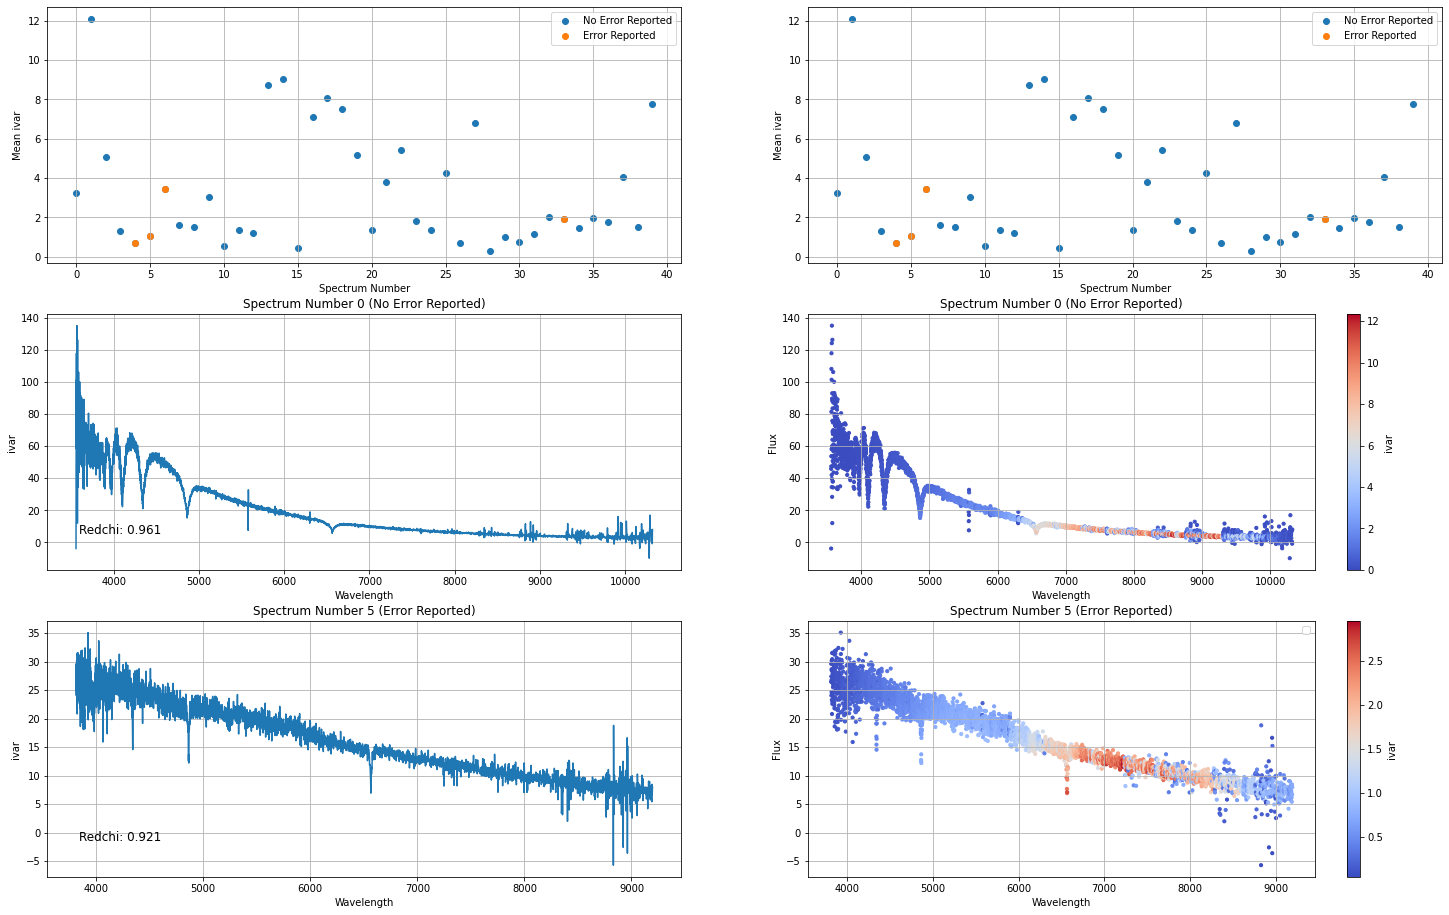

In [100]:
plt.figure(figsize=(25,16))


has_erv = []
for i in range(len(catalog)):
    if catalog['e_rv'][i] > 1e-4:
        has_erv.append([i, np.mean(catalog['wd_ivar'][i])])
        
has_erv = np.array(has_erv).T

num = np.array([i for i in range(len(catalog))])
mean_ivar = np.array([np.mean(catalog['wd_ivar'][i]) for i in range(len(catalog))])

'''
===============================================
                Plot One
===============================================
'''

i = [0,5]

plt.subplot(3,2,1)
plt.scatter(num, mean_ivar, label = 'No Error Reported')
plt.scatter(has_erv[0], has_erv[1], label = 'Error Reported')

#plt.hlines(1, 0, 40)
plt.grid()
plt.ylabel(r'Mean ivar')
plt.xlabel(r'Spectrum Number')
#plt.title('White Dwarf Spectrum')
plt.legend()

plt.subplot(3,2,2)

plt.scatter(num, mean_ivar, label = 'No Error Reported')
plt.scatter(has_erv[0], has_erv[1], label = 'Error Reported')

#plt.hlines(1, 0, 40)
plt.grid()
plt.ylabel(r'Mean ivar')
plt.xlabel(r'Spectrum Number')
plt.legend()

'''
===============================================
    Plot Two
===============================================
'''

plt.subplot(3,2,3)

plt.plot(catalog['wd_wl'][i[0]], catalog['wd_fl'][i[0]])
plt.text(0.05, 0.14, 'Redchi: {}'.format(round(catalog['rechi'][i[0]], 3)), fontsize=12,
                transform = plt.gca().transAxes)

plt.grid()
plt.ylabel(r'ivar')
plt.xlabel(r'Wavelength')
plt.title('Spectrum Number {} (No Error Reported)'.format(i[0]))

plt.subplot(3,2,4)
color = plt.cm.coolwarm(catalog['wd_ivar'][i[0]])
plt.scatter(catalog['wd_wl'][i[0]], catalog['wd_fl'][i[0]], c=catalog['wd_ivar'][i[0]], cmap = 'coolwarm', s=10)

plt.grid()
plt.ylabel(r'Flux')
plt.xlabel(r'Wavelength')
plt.title('Spectrum Number {} (No Error Reported)'.format(i[0]))
plt.colorbar(label='ivar')

'''
===============================================
    Plot Three
===============================================
'''

plt.subplot(3,2,5)

plt.plot(catalog['wd_wl'][i[1]], catalog['wd_fl'][i[1]])
plt.text(0.05, 0.14, 'Redchi: {}'.format(round(catalog['rechi'][i[1]], 3)), fontsize=12,
                transform = plt.gca().transAxes)


plt.grid()
plt.ylabel(r'ivar')
plt.xlabel(r'Wavelength')
plt.title('Spectrum Number {} (Error Reported)'.format(i[1]))

plt.subplot(3,2,6)
#color = plt.cm.coolwarm(catalog['wd_ivar'][i])
plt.scatter(catalog['wd_wl'][i[1]], catalog['wd_fl'][i[1]], c=catalog['wd_ivar'][i[1]], cmap = 'coolwarm', s=10)

plt.grid()
plt.ylabel(r'Flux')
plt.xlabel(r'Wavelength')
plt.title('Spectrum Number {} (Error Reported)'.format(i[1]))
plt.legend()
plt.colorbar(label='ivar')


plt.show()

In [101]:
print(catalog[['rv','e_rv']])

        rv                e_rv       
------------------ ------------------
 58.76472793145922              1e-06
17.956898769676627              1e-06
  8.62828924751193              1e-06
  47.5778594349963              1e-06
 46.01459582385223 2.1672810535439053
 90.57930371597695 1.5335434749811292
 95.69521709948367 13.579735187030625
32.570667156625404              1e-06
 7.275040641879059              1e-06
41.144567141941934              1e-06
22.197477817368508              1e-06
               ...                ...
 20.71598010561729              1e-06
31.268690783895636              1e-06
14.128956793022553              1e-06
 26.46300295072615              1e-06
127.80612201220993 23.278694011983703
 38.98814809963369              1e-06
 55.43763499326815              1e-06
42.041169576274115              1e-06
 42.07683238033678              1e-06
 48.89508799297346              1e-06
 6.978585663541708              1e-06
Length = 40 rows


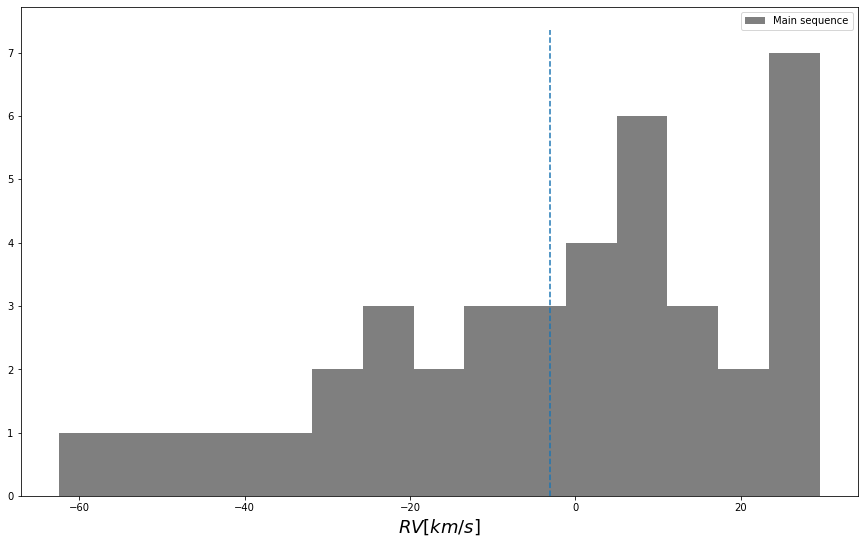

In [102]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 9))
#axes.grid()
axes.hist(catalog['ms_rv'], bins = 15, alpha=0.5, color='black', label='Main sequence')
#axes.hist(catalog['rv'], bins = 15, alpha=0.5, color='red', label='White dwarf')
ymin, ymax = axes.get_ylim()
axes.vlines(np.mean(catalog['ms_rv']), ymin, ymax, linestyles='dashed')
#axes.vlines(np.mean(catalog['rv']), ymin, ymax, linestyles='dashed', color='red')

#axes[0].set_title('Gravitational Redshift', fontsize=20)
axes.set_xlabel(r'$RV [km/s]$', fontsize=18)
axes.legend()

37.00651665948366
40


Text(0.5, 0, '$RV_{MS} - RV_{WD}$')

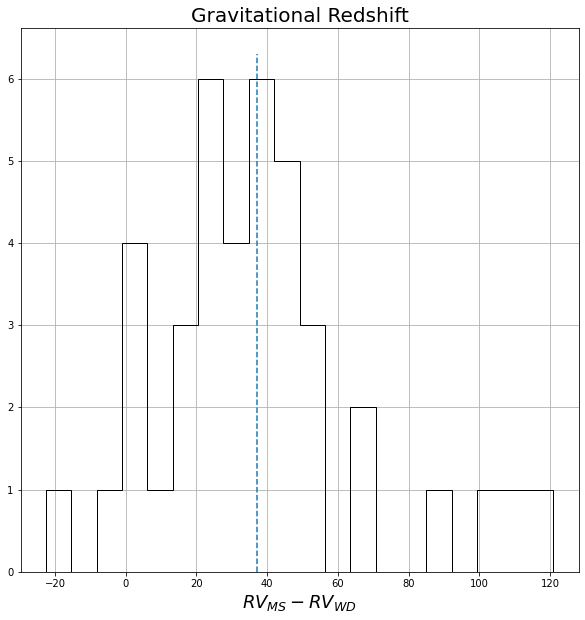

In [103]:
catalog['g_redshift'] = catalog['rv'] - catalog['ms_rv']
catalog['eg_redshift'] = catalog['ms_erv'] + catalog['e_rv']

#catalog = catalog[catalog['g_redshift'] > -100]
#catalog = catalog[catalog['g_redshift'] < 100]

print(np.mean(catalog['g_redshift']))
print(len(catalog))


plt.figure(figsize=(10,10))
plt.grid()
plt.hist(catalog['g_redshift'], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog['g_redshift']), ymin, ymax, linestyles='dashed')
plt.title('Gravitational Redshift', fontsize=20)
plt.xlabel(r'$RV_{MS} - RV_{WD}$', fontsize=18)

In [27]:
for col in catalog.columns:
    if catalog[col].dtype == object: print(col)

wd_wl
wd_fl
wd_ivar


In [28]:
catalog.remove_columns(['wd_wl', 'wd_fl', 'wd_ivar'])

catalog.write('data/02_wd_rvs.fits', format='fits', overwrite=True)